## Test kernel computations found in the litterature

In [1]:
import numpy as np
from numpy import pi, tan, cos, sin
from numpy import arctan, sqrt, arccos
import matplotlib.pyplot as plt

### Helper functions


In [2]:
def deg2rad(x):
    """Convert degrees to radians"""
    return x * np.pi / 180

def rad2deg(x):
    """Convert degrees to radians"""
    return x / np.pi * 180

def relative_azimuth(saa, vaa):
    """Calculate the relative azimuth angle between a SAA and VAA.
       In Radians."""
    return np.abs(vaa - np.pi - saa);

# 1. Kgeo

### HDF tools

In [3]:
def kgeo_hdf(solZn,viewZn,relAz, li="sparse"):
    # Eq. 37,52. Wanner et al. JGRA 1995
    solZn_ = np.arctan(1* np.tan(solZn))
    viewZn_ = np.arctan(1* np.tan(viewZn))
    # Eq 50. Wanner et al. JGRA 1995
    D = np.sqrt((np.tan(solZn_)**2) + (np.tan(viewZn_)**2) - 2*np.tan(solZn_)*np.tan(viewZn_)*np.cos(relAz))    
    # Eq 49. Wanner et al. JGRA 1995
    t_num = 2. * np.sqrt(D**2 + (np.tan(solZn_)*np.tan(viewZn_)*np.sin(relAz))**2) 
    t_denom = (1/np.cos(solZn_))  + (1/np.cos(viewZn_))
    t = np.arccos(np.clip(t_num/t_denom,-1,1))
    # Eq 33,48. Wanner et al. JGRA 1995
    O = (1/np.pi) * (t - np.sin(t)*np.cos(t)) * t_denom
    # Eq 51. Wanner et al. JGRA 1995
    cosPhase_ =  np.cos(solZn_)*np.cos(viewZn_) + np.sin(solZn_)*np.sin(viewZn_)*np.cos(relAz)
    if li == 'sparse':
        # Eq 32. Wanner et al. JGRA 1995
        kGeo = O - (1/np.cos(solZn_)) - (1/np.cos(viewZn_)) + .5*(1+ cosPhase_) * (1/np.cos(viewZn_))
    elif li == 'dense':
        # Eq 47. Wanner et al. JGRA 1995
        kGeo = (((1+cosPhase_) * (1/np.cos(viewZn_)))/ (t_denom - O)) - 2
    
    return kGeo

## GEOS

In [4]:
def geos(sza, vza, raa):
    # Calculate Rgeo
    h_b  = 2.0
    b_r  = 1.0

    szaP        = arctan(b_r*tan(sza))
    vzaP        = arctan(b_r*tan(vza))
    cos_thetaP  = cos(szaP)*cos(vzaP) + sin(szaP)*sin(vzaP)*cos(raa)
    dP          = sqrt(tan(vzaP)*tan(vzaP) + tan(szaP)*tan(szaP) - 2.0*tan(vzaP)*tan(szaP)*cos(raa))
    amfP        = (1./cos(vzaP)) + (1./cos(szaP))
    temp        = h_b*sqrt(dP*dP + (tan(szaP)*tan(vzaP)*sin(raa))*(tan(szaP)*tan(vzaP)*sin(raa)))/amfP
    cos_t       = np.min([1,temp])       
    t           = arccos(cos_t)
    sin_t       = sin(t)
    O           = (1.0-(1./pi)*(t-sin_t*cos_t))*amfP

    Rgeo        = 0.5*(1+cos_thetaP)*(1./cos(vzaP))*(1./cos(szaP)) - O
    
    return Rgeo

## SEPAL

In [5]:
def calc_kvol(sunAz, sunZen, viewAz, viewZen):
    """Calculate kvol kernel.
    From Lucht et al. 2000
    Phase angle = cos(solar zenith) cos(view zenith) + sin(solar zenith) sin(view zenith) cos(relative azimuth)"""
    relative_azimuth = sunAz -viewAz
    pa1 = np.cos(viewZen) * np.cos(sunZen)
    pa2 = np.sin(viewZen) * np.sin(sunZen) * np.cos(relative_azimuth)
    phase_angle1 = pa1+pa2
    phase_angle = np.arccos(phase_angle1)
    p1 = np.pi / 2 - phase_angle
    p2 = p1 * phase_angle1
    p3 = p2 + np.sin(phase_angle)
    p4 = np.cos(sunZen) + np.cos(viewZen)
    p5 = np.pi / 4

    kvol = p3 / p4 - p5

    viewZen0 = 0
    pa10 = np.cos(viewZen0) * np.cos(sunZen)
    pa20 = np.sin(viewZen0) * np.sin(sunZen) * np.cos(relative_azimuth)
    phase_angle10 = pa10 + pa20
    phase_angle0 = np.arccos(phase_angle10)
    p10 = np.pi / 2 - phase_angle0
    p20 = p10 * phase_angle10
    p30 = p20 + np.sin(phase_angle0)
    p40 = np.cos(sunZen) + np.cos(viewZen0)
    p50 = np.pi / 4

    kvol0 = p30 / p40 - p50

    return kvol0

In [6]:
# Set angles for testing

SZA = 45
SAA = 180
VAA = 0
VZA = range(0,90, 10)

# Initialise angles and results
angles = []
hdf_sparse_results = []
hdf_thick_results = []
geos_results = []
sepal_results = []

for i in VZA:
    sza = deg2rad(SZA)
    saa = deg2rad(SAA)
    vza = deg2rad(i)
    vaa = deg2rad(VAA)
    
    raa = relative_azimuth(saa, vaa)
    
    angles.append(i)
    
    # HDF
    hdf_sparse_results.append(kgeo_hdf(sza, vza, raa, li="sparse"))
    hdf_thick_results.append(kgeo_hdf(sza, vza, raa, li="dense"))
    
    # GEOS
    geos_results.append(geos(sza, vza, raa))
    
    # SEPAL
    sepal_results.append(calc_kvol(saa, sza, vaa, vza))
      

## Javascript code k_geo.js

See code below. Run in Js outside this notebook.


In [7]:
js_angles = [0, 10, 20, 30, 40, 50, 60, 70, 80]
js_plane = [-1.1068191757647372, -0.870291742911339, -0.5774284042327373, -0.20754458417742372, 0.2784160828371678, 0.4675029273554563, 0.17046782583454645, -0.1803839029808496, 0.23472252421991957]
js_cross = [-1.1068191757647372, -1.1275104677609415, -1.1847095679749289, -1.2524175198246204, -1.2965585052081703, -1.3698745216070236, -1.4999999999999998, -1.7705760443177971, -2.600918385588934]

In [8]:
"""
function deg2rad(x){
  // Convert degrees to radians
  return x * Math.PI / 180;
}

function rad2deg(x){
  // Convert degrees to radians
  return x / Math.PI * 180;
}

function sec(x){
  // Calculate the secant of a value
  return 1 / Math.cos(x);
}

function relative_azimuth(saa, vaa){
  // Calculate relative azimuth angle
  // Angles in RAD !
  // return vaa - saa;
  return Math.abs(vaa - Math.PI - saa);
}

function calc_Kgeo(sza, vza, saa, vaa){
  // Calculate the LiSparse kernel from Lucht et al. 2000
  // Angles in RAD !

  // Relative azimuth
  var phi = relative_azimuth(vaa, saa)
  
  // theta_prime = Math.atan(b / r * Math.tan(sza)) simplifies because b/r = 1
  var theta_prime = sza
  // vartheta_prime = Math.atan(b / r * Math.tan(vza)) simplifies because b/r = 1
  var vartheta_prime =  vza

  var cos_xi_prime = Math.cos(theta_prime) * Math.cos(vartheta_prime) + Math.sin(theta_prime) * Math.sin(vartheta_prime) * Math.cos(phi);

  // Calculate t, broken up for clarity
  // h / b = 2
  var D = Math.sqrt(Math.pow(Math.tan(theta_prime), 2) + Math.pow(Math.tan(vartheta_prime), 2) - 2 * Math.tan(theta_prime) * Math.tan(vartheta_prime) * Math.cos(phi));
  var tantansin = Math.tan(theta_prime) * Math.tan(vartheta_prime) * Math.sin(phi);
  var costtop = Math.sqrt(Math.pow(D, 2) + Math.pow(tantansin, 2))
  var cost = 2 * costtop / (sec(theta_prime) + sec(vartheta_prime))
  var t = Math.acos(Math.min(1, cost));

  // Calculate O
  var O = (1 / Math.PI) * (t - Math.sin(t) * Math.cos(t)) * (sec(theta_prime) + sec(vartheta_prime));

  // Kgeo
  kgeo = O - sec(theta_prime) - sec(vartheta_prime) + 1 / 2 * (1 + cos_xi_prime) * sec(theta_prime) * sec(vartheta_prime);

  return kgeo;
}


var SZA = 45
var SAA = 180
var VAA = 0

// Initialise angles and results
var angles = []
var results = []

for (i=0;i<90; i+=10){
    var sza = deg2rad(SZA)
    var saa = deg2rad(SAA)
    var vza = deg2rad(i)
    var vaa = deg2rad(VAA)
    
    var raa = relative_azimuth(saa, vaa)
    
    angles.push(i)
    
    // HDF
    results.push(calc_Kgeo(sza, vza, saa, vaa))   
}

console.log(angles)
console.log(results)
"""

'\nfunction deg2rad(x){\n  // Convert degrees to radians\n  return x * Math.PI / 180;\n}\n\nfunction rad2deg(x){\n  // Convert degrees to radians\n  return x / Math.PI * 180;\n}\n\nfunction sec(x){\n  // Calculate the secant of a value\n  return 1 / Math.cos(x);\n}\n\nfunction relative_azimuth(saa, vaa){\n  // Calculate relative azimuth angle\n  // Angles in RAD !\n  // return vaa - saa;\n  return Math.abs(vaa - Math.PI - saa);\n}\n\nfunction calc_Kgeo(sza, vza, saa, vaa){\n  // Calculate the LiSparse kernel from Lucht et al. 2000\n  // Angles in RAD !\n\n  // Relative azimuth\n  var phi = relative_azimuth(vaa, saa)\n  \n  // theta_prime = Math.atan(b / r * Math.tan(sza)) simplifies because b/r = 1\n  var theta_prime = sza\n  // vartheta_prime = Math.atan(b / r * Math.tan(vza)) simplifies because b/r = 1\n  var vartheta_prime =  vza\n\n  var cos_xi_prime = Math.cos(theta_prime) * Math.cos(vartheta_prime) + Math.sin(theta_prime) * Math.sin(vartheta_prime) * Math.cos(phi);\n\n  // Calcul

## From paper

In [9]:
paper_angles = [1.3435899819501458, 5.839162735209584,12.424488910579697,
                17.793271204691393,21.972778048912744,25.251806920913793,
                30.00890872047532,35.63922006088916,39.7778242580585,
                41.84030924880119,43.311565068519684,47.28407972917489,
                53.08481876563866,58.603577432274335,62.29411172310145,
                65.6617629970485,68.73379968548343,72.67904591477065,75.6351917698916,
                77.0859962660841]
paper_kgeo_plane = [-0.5164423993120923,-0.46680145948081586,-0.38415952032350376,
                    -0.2934455057441885,-0.2274435070921168,-0.16973049183883804,
                    -0.07088242812986634,0.06903871032714282,0.1842168460030824,
                    0.25000193667836346,0.2993330079713674,0.2505597000472539,
                    0.18558026757148216,0.0959817797299487,0.02258941644007484,
                    -0.026245865191692808,-0.08330815651459922,-0.09929737308946773,
                    -0.017027276178082307,0.05689186362685561]

In [10]:
paper_angles_cross = [2.404664630518454,9.455555114830844,18.06639958748167,
                      26.371345841101117,34.03403276347626,42.35421046368651,
                      50.04736027924321,59.05549165047003,65.29530760382374,70.96902145888703, 76.55007734718976,
                      77.63531791678236]
paper_kgeo_cross = [-0.5686406727222244,-0.5765737178215864,-0.6010233628178185,-0.6254888739042483,
                    -0.6333901868232128,-0.6661536630835752,-0.6906509063504029,-0.7648724763000283,
                    -0.8309388758875094,-0.9219309031771847,-1.1291103089921068,-1.2203403276347626]

## Plotting

### Along plane

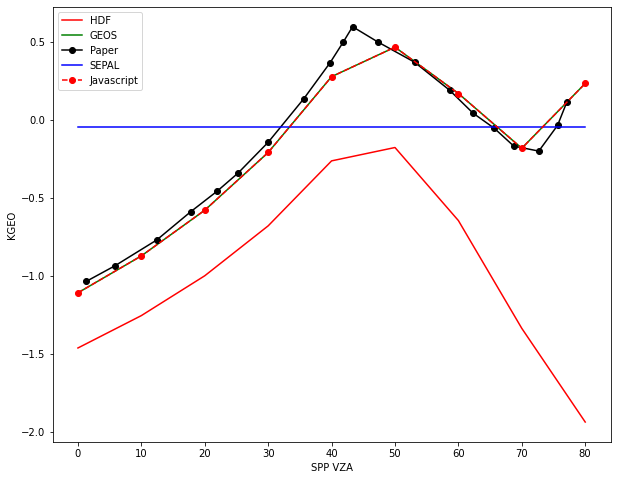

In [11]:
pt, ax = plt.subplots(1, figsize=(10,8))
ax.plot(angles, hdf_sparse_results, "r", linestyle="-", label="HDF")
ax.plot(angles, geos_results, "g", linestyle="-", label="GEOS")
ax.plot(paper_angles, [x * 2 for x in paper_kgeo_plane], "ok-", label="Paper")
ax.plot(angles, sepal_results, "b-", label="SEPAL")
ax.plot(js_angles, js_plane, "or--", label="Javascript")
ax.set_xlabel("SPP VZA")
ax.set_ylabel("KGEO")
plt.legend()
plt.show()

### Cross-plane

In [12]:
# Set angles for testing

SZA = 45
SAA = 90
VAA = 0
VZA = range(0,90, 10)

# Initialise angles and results
angles = []
hdf_sparse_results = []
hdf_thick_results = []
geos_results = []
sepal_results = []

for i in VZA:
    sza = deg2rad(SZA)
    saa = deg2rad(SAA)
    vza = deg2rad(i)
    vaa = deg2rad(VAA)
    
    raa = relative_azimuth(saa, vaa)
    
    angles.append(i)
    
    # HDF
    hdf_sparse_results.append(kgeo_hdf(sza, vza, raa, li="sparse"))
    hdf_thick_results.append(kgeo_hdf(sza, vza, raa, li="dense"))
    
    # GEOS
    geos_results.append(geos(sza, vza, raa))
    
    # SEPAL
    sepal_results.append(calc_kvol(saa, sza, vaa, vza))
      

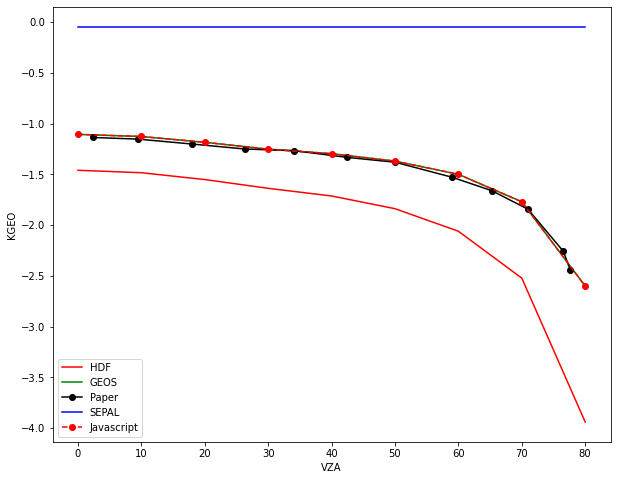

In [13]:
pt, ax = plt.subplots(1, figsize=(10,8))
ax.plot(angles, hdf_sparse_results, "r", linestyle="-", label="HDF")
ax.plot(angles, geos_results, "g", linestyle="-", label="GEOS")
ax.plot(paper_angles_cross, [x *2 for x in paper_kgeo_cross], "ok-", label="Paper")
ax.plot(angles, sepal_results, "b-", label="SEPAL")
ax.plot(js_angles, js_cross, "ro--", label="Javascript")
ax.set_xlabel("VZA")
ax.set_ylabel("KGEO")
plt.legend()
plt.show()